In [1]:
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
import warnings

catalog_path='/Users/EvanB.LAPTOP-8CHCIOMA/Downloads/'

#A100-NSA Catalog
myTab=Table.read(catalog_path+'a100-nsa-for-adap.fits')

In [2]:
# R-band Magnitude Limit
Mrmax = -18.2
Mr = myTab['ABSMAG'][:,4] # R-band magnitude from catalog
Mrflag = Mr < Mrmax # Cuts r-band magnitudes greater than the max r-band magnitude limit

# Velocity input
vinput = int(input()) # Asks for a velocity to create a new cut based off of
v = myTab['Vhelio'] # Recessional velocity from catalog
vflag = (v > -1*vinput) & (v < vinput) # Applies a cut (+/- the input velocity) to the data set 

cut = Mrflag & vflag # Combines both cuts

cuttab = myTab[cut]

 1500


# Computing 5th Nearest Neighbor

In [3]:
ra = np.array(cuttab['RA']) # Right ascension of each galaxy
dec = np.array(cuttab['DEC']) # Declination of each galaxy

points = []
for i in range(len(dec)):
    points.append((ra[i],dec[i])) # Array of tuples of ra and dec (each galaxy now represented by a point)

def distance(ra1, dec1, ra2, dec2):
    return ((ra1 - ra2) ** 2 + (dec1 - dec2) ** 2) ** ( 1 / 2) # Distance between two points    

def Five_Nearest(points, target, K):
    pts = []
    n = len(points)
    d = []
 
    for i in range(n):
        d.append({
            "first": distance(points[i][0], points[i][1], target[0], target[1]), # Finds distance between target point and another point
            "second": i # Stores new point that had its distance relative to the target found
        })
     
    d = sorted(d, key=lambda l:l["first"]) # Sorts d from smallest to largest distance for each target point
 
    for i in range(K): # Loops through for however many times are specified by K (I will use K=6)
        pt = []
        pt.append(points[d[i]["second"]][0]) # First element of a tuple in an array of nearest points sorted by distance
        pt.append(points[d[i]["second"]][1]) # Second element of a tuple in an array of nearest points sorted by distance
        pts.append(pt) # Stores all individual pt values as tuples
 
    return pts # Returns the six nearest galaxies to a target galaxy (the first of which is the original target galaxy)


In [4]:
# Find five nearest galaxies to each galaxy

five_nn = [] # Store nearest neighbors
K = 6 # Number of times to calaculate nearest neighbors

for i in range(len(points)):
    target = points[i] # Switches target point
    for pt in Five_Nearest(points, target, K): # Calculates five nearest points for each points in points and stores them along with their targets
        five_nn.append((pt[0], pt[1])) # Includes six points for each target, the first of which in each set is the target itself

In [5]:
print(five_nn[0])

(0.8125990364294372, 16.14570390458945)


In [6]:
# Separating target points from fifth nearest points

target_fnn = points #five_nn[0::6] # list of original target galaxies
fifth_nearest_neighbors = five_nn[5::6] # fifth nearest point of each target

print('FNN:',fifth_nearest_neighbors[0:2])
print('Targets:',target_fnn[0:2])

FNN: [(2.1247261268751685, 18.324074686728974), (5.8267271563667835, 13.70221435354031)]
Targets: [(0.8125990364294372, 16.14570390458945), (4.439792860539326, 11.450287516539865)]


In [7]:
# Finding angular distance

dist_fifthnn = []

# Calculates distance between each galaxy and its fifth nearest meighbor

for i in range(len(fifth_nearest_neighbors)):
    target0 = target_fnn[i] # Changes target on each loop through
    dist_fifthnn.append(distance(fifth_nearest_neighbors[i][0], fifth_nearest_neighbors[i][1], target0[0], target0[1])) # Produces distance array
 
angle = np.array(dist_fifthnn)
print(angle[0:2])

[2.54302512 2.64476109]


In [8]:
# Redshifts of fifth nearest neighbors

# This compares each point in fifth nearest neighbors to each point in points and stores their respective z values
z_fnn = []
for i in range(len(fifth_nearest_neighbors)):
    for j in range(len(points)): 
        if fifth_nearest_neighbors[i][0] == points[j][0]:
            z_fnn.append(cuttab['ZDIST'][j]) 

In [20]:
z_fnn[0]

0.019063886

In [10]:
# Converting angular distances to kpc

# Array of redshifts for each fifth nearest neighbor
z = np.array(z_fnn)

# Convert angles in degrees to radians
radians = (np.pi/180)*(angle)

# Finding distance, in m, between the Sun and the galaxies
H0 = 2.3*10**(-18) #/s
c = 3*10**8 #m/s

v = z*c 
d = v/H0 #m

# Using small angle approximation to convert to kpc
r_5 = (d*radians)*(3*10**(-19)) #kpc
print(r_5[0:2])

[33109.61489881 31383.58832115]


In [11]:
# Find fifth nearest neighbor density
sigma_5 = 1/(r_5**2)
print(sigma_5[0:10]) # \kpc^2

[9.12203514e-10 1.01530098e-09 6.12842822e-09 4.34180232e-10
 1.71615168e-09 1.03586089e-08 7.27203446e-07 5.33490190e-09
 2.48354513e-10 8.34796868e-10]


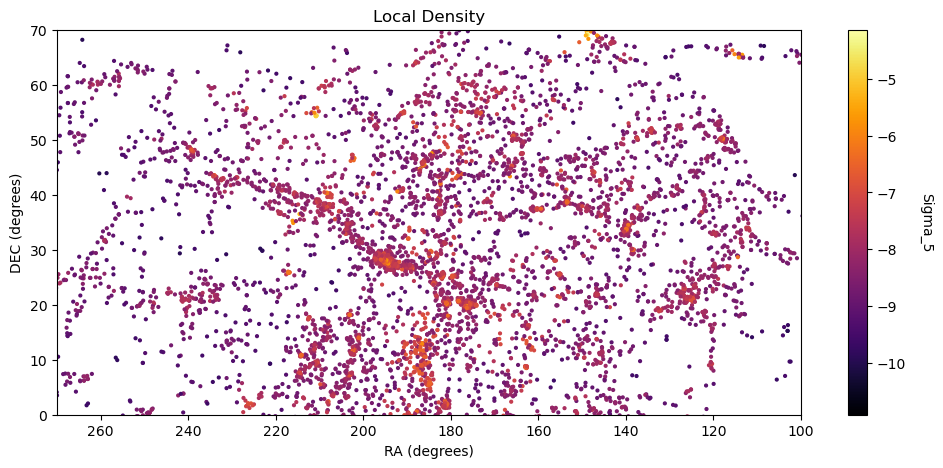

In [37]:
ra = cuttab['RA']
dec = cuttab['DEC']
ccode = np.log10(sigma_5)

#Plot RA vs DEC and color it by local density
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='inferno',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('Local Density')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('Sigma_5',rotation=270,labelpad=20)

## Ignore

C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_6072\1477793577.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(ra2,dec2,c=ccode,cmap='viridis',s=4) # ,alpha=0.8


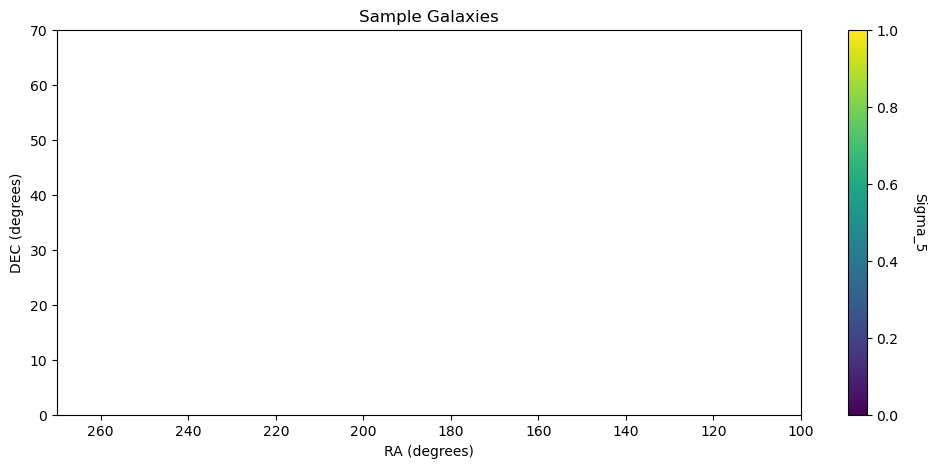

In [29]:
# Redshift slice
zdist1 = myTab['ZDIST'] 
zflag1 = (zdist1 > 0.002) & (zdist1 < 0.010)
cuts1 = cut & zflag1
cuttab2 = myTab[cuts1]


ra2 = np.array(cuttab2['RA']) # Right ascension of each galaxy
dec2 = np.array(cuttab2['DEC']) # Declination of each galaxy

points2 = []
for i in range(len(dec2)):
    points2.append((ra2[i],dec2[i])) # Array of tuples of ra and dec (each galaxy now represented by a point) 


sigma_5_cuttab2 = []
for i in range(len(sigma_5)):
    for j in range(len(points2)): 
        if sigma_5[i] == points2[j][0]:
            sigma_5_cuttab2.append(sigma_5[i]) 


#ra = cuttab2['RA']
#dec = cuttab2['DEC']
ccode = np.log10(sigma_5_cuttab2)

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra2,dec2,c=ccode,cmap='viridis',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('Sample Galaxies')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('Sigma_5',rotation=270,labelpad=20)